In [1]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import tqdm
import numpy as np

In [2]:
import networkx as nx

import dgl
from dgl.nn import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)

In [5]:
dataset

Dataset("PROTEINS", num_graphs=1113, save_path=/Users/marc/.dgl/PROTEINS_0c2c49a1)

In [6]:
graphs = dataset[:][0]

In [7]:
graphs

[Graph(num_nodes=42, num_edges=204,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=27, num_edges=119,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=10, num_edges=44,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=24, num_edges=116,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=11, num_edges=53,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=336, num_edges=1968,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32)

In [8]:
targets = dataset[:][1]

In [9]:
targets

tensor([0, 0, 0,  ..., 1, 1, 1])

In [10]:
torch.bincount(targets)

tensor([663, 450])

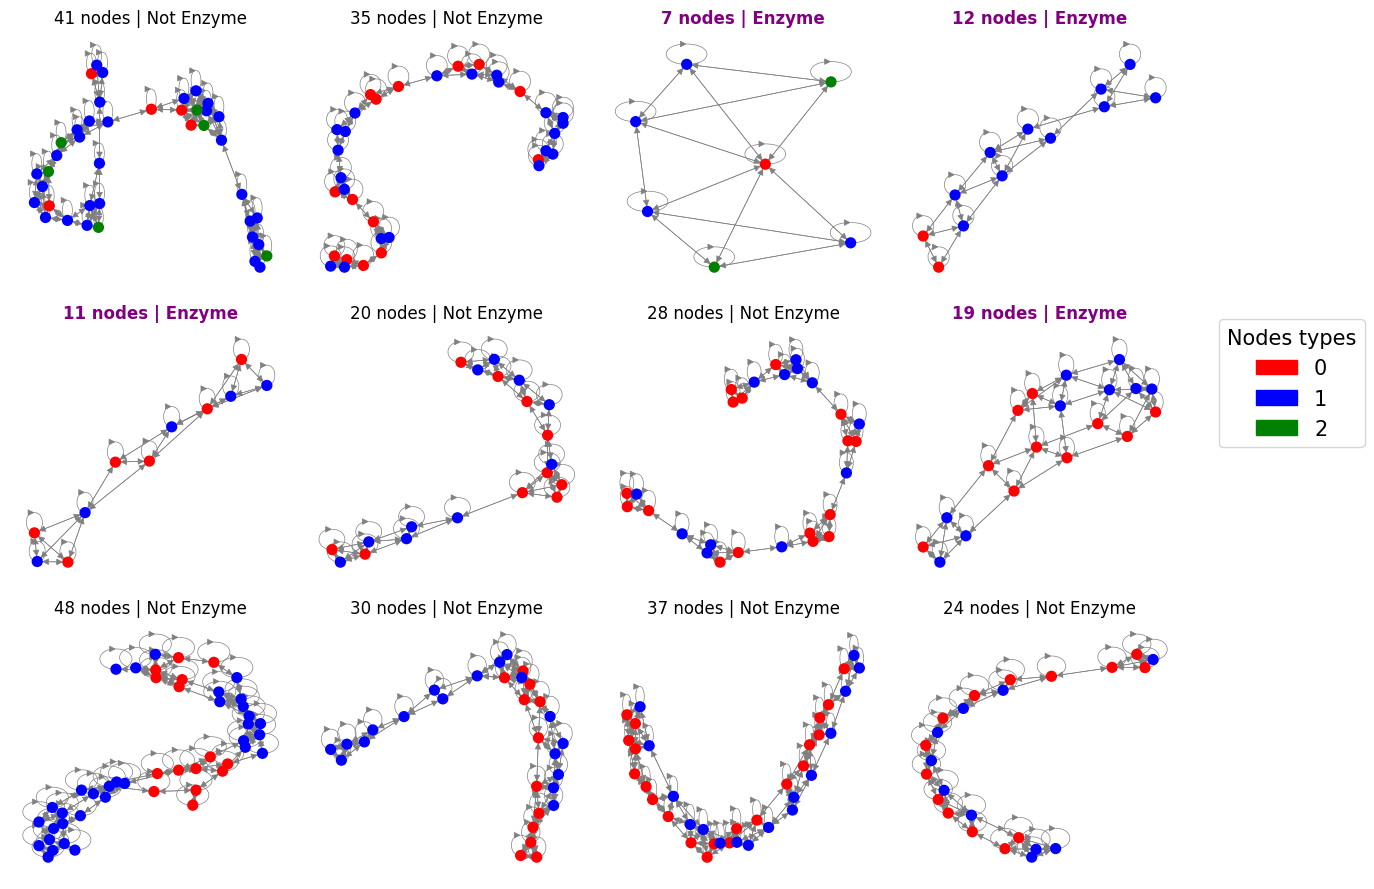

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()
options = {
    "node_size": 50,
    "width": 0.5,
}

for pos in axes:
    random_index = random.randint(0,len(graphs)-1)
    g = graphs[random_index]
    t = targets[random_index]
    labels = g.ndata["label"].numpy()

    label_dict = {i: str(label) for i, label in enumerate(labels)}

    color_dict = {0: "red", 1: "blue", 2: "green"}

    node_colors = [color_dict[label] for label in labels]

    nx.draw(
        g.to_networkx(),
        node_color=node_colors,
        #labels=label_dict,
        #with_labels=True,
        edge_color="gray",
        ax=pos,
        **options
    )
    
    pos.set_title(f'{g.number_of_nodes()} nodes {"| Enzyme" if t==1 else "| Not Enzyme"}',color='Purple' if t==1 else 'Black', fontweight= "bold" if t==1 else 'regular')


legend_labels = ["0", "1", "2"]
legend_colors = ["red", "blue", "green"]
legend_handles = [
    Patch(color=color, label=label)
    for color, label in zip(legend_colors, legend_labels)
]
plt.figlegend(handles=legend_handles, loc="upper right", title="Nodes types",bbox_to_anchor=(1.15,0.65), fontsize="15", title_fontsize="15")
plt.tight_layout()
plt.show()

In [12]:
protein = [(graph.number_of_nodes(), graph.number_of_edges()) for graph, target in dataset if target]
other = [(graph.number_of_nodes(), graph.number_of_edges()) for graph, target in dataset if not target]

In [94]:
print('enzymes')
nodes, edges = zip(*protein)
print(f'mean nodes : {np.median(nodes):.0F}')
print(f'quartile nodes : {np.quantile(nodes, 0.75):.0F}')
print(f'mean edges : {np.median(edges):.0F}')
print(f'quartile edges : {np.quantile(edges, 0.75):.0F}')
print('other')
nodes, edges = zip(*other)
print(f'mean nodes : {np.median(nodes):.0F}')
print(f'quartile nodes : {np.quantile(nodes, 0.75):.0F}')
print(f'mean edges : {np.median(edges):.0F}')

enzymes
mean nodes : 16
quartile nodes : 28
mean edges : 77
quartile edges : 132
other
mean nodes : 34
quartile nodes : 59
mean edges : 165


In [38]:
train_dataset, temp_dataset = train_test_split(
    dataset, test_size=0.3, random_state=42, stratify=dataset
[:][1])
test_dataset, valid_dataset = train_test_split(
    temp_dataset, test_size=0.3, random_state=42
)

In [89]:
quick_pred = [torch.tensor(1) if (graph.number_of_nodes()<=28 and graph.number_of_edges()<=132) else torch.tensor(0) for graph, _ in valid_dataset ]
t = [t for graph, t in valid_dataset]

In [90]:
len(quick_pred)

101

In [91]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [92]:
print(classification_report(t, quick_pred))

              precision    recall  f1-score   support

           0       0.83      0.60      0.69        57
           1       0.62      0.84      0.71        44

    accuracy                           0.70       101
   macro avg       0.72      0.72      0.70       101
weighted avg       0.74      0.70      0.70       101



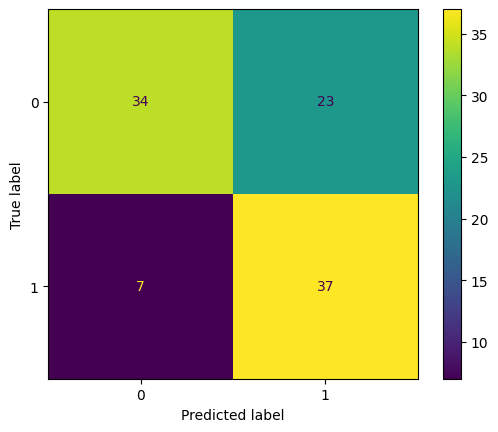

In [93]:
ConfusionMatrixDisplay(confusion_matrix(t, quick_pred)).plot()

In [44]:
seperation = ['Protein'] * len(protein) + ['Other'] * len(other)

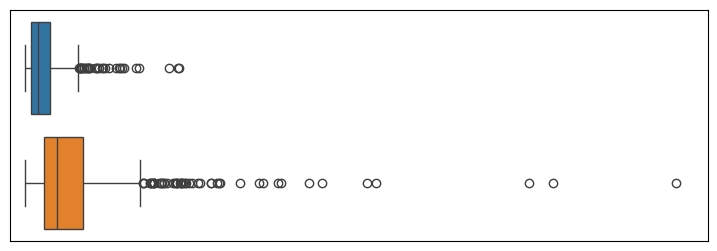

In [128]:
plt.figure(figsize=(9, 3))

sns.boxplot(
    y=seperation,
    x=[item[0] for item in protein + other],
    hue=seperation,
    orient='h'
    )

plt.xlim(-10, 650)

plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.show()

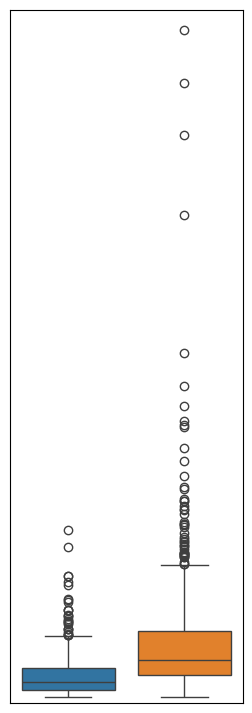

In [125]:
plt.figure(figsize=(3, 9))

sns.boxplot(
    x=seperation,
    y=[item[1] for item in protein + other],
    hue=seperation
)

plt.ylim(-10, 2800)


plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.show()


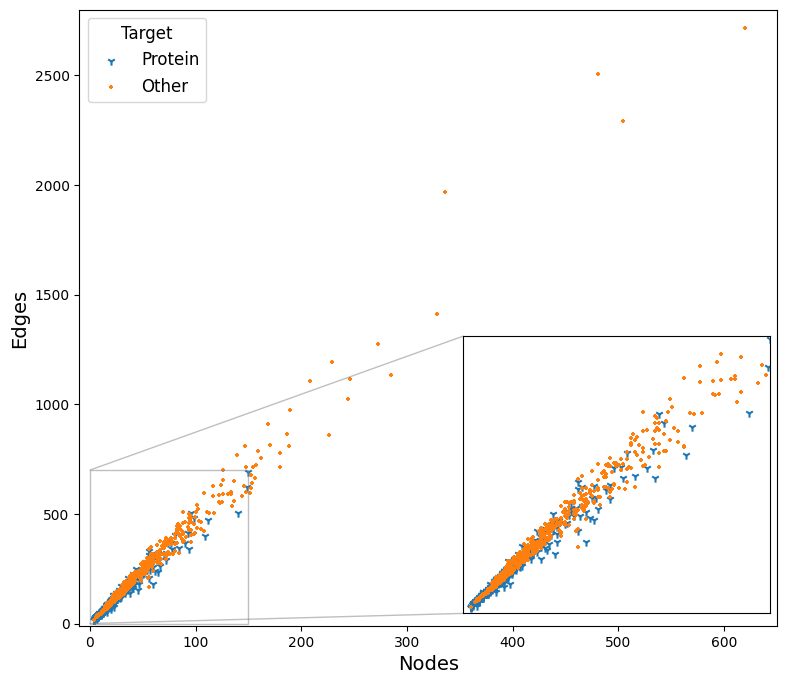

In [124]:
_, ax = plt.subplots(figsize=[9, 8])

ax.scatter(*zip(*protein), marker="1", label="Protein")
ax.scatter(*zip(*other), marker="+", s=5, label="Other")
ax.set_xlabel('Nodes', fontsize=14)
ax.set_ylabel('Edges', fontsize=14)

axin = ax.inset_axes(bounds=[0.55, 0.02, 0.44, 0.45])
axin.scatter(*zip(*protein), marker="1")
axin.scatter(*zip(*other), marker="+", s=5)
axin.set_xlim(0, 150)
axin.set_ylim(0, 700)
ax.indicate_inset_zoom(axin)
axin.set_yticks([])
axin.set_xticks([])

ax.set_xlim(-10, 650)
ax.set_ylim(-10, 2800)

legend = ax.legend(fontsize='large', loc='upper left')
legend.set_title("Target", prop={'size': 'large'})
plt.show()

In [14]:
train_dataset, test_dataset = train_test_split(
    dataset,
    test_size=0.1, 
    random_state=42, 
    stratify=dataset[:][1]
    )

In [15]:
train_dataset, val_dataset = train_test_split(
    train_dataset,
    test_size=0.2, 
    random_state=42, 
    stratify=[graphs[1] for graphs in train_dataset]
    )

In [16]:
len(train_dataset), len(val_dataset), len(test_dataset)

(800, 201, 112)

In [17]:
from dgl.dataloading import GraphDataLoader
batch_size = 32
print(f"batch_size : {batch_size} ")
train_dataloader = GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = GraphDataLoader(val_dataset, batch_size=batch_size, shuffle=True)

batch_size : 32 


In [18]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats[0])
        self.conv2 = GraphConv(h_feats[0], h_feats[1])
        self.conv3 = GraphConv(h_feats[1], num_classes)
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')
    
    def predict(self, dataset) :
        self.eval()
        predictions = []
        with torch.no_grad():
            for g, _ in dataset:
                pred = F.softmax(self.forward(g, g.ndata["attr"].float()), dim=1)
                predictions.extend(pred)
        return predictions
    
    def fit(self,optimizer, train_dataset, epoochs, val_dataset):
        history = {
            "loss":[],
            "val_loss":[],
            "acc":[],
            'val_acc':[]
        } 
        train_label = torch.cat([l for g, l in train_dataset])
        val_label = torch.cat([l for g, l in val_dataset])
        
        for e in range(epoochs) :
            print(f'Epoch {e+1}', end = " : ")
            
            #train
            self.train()
            
            train_loss = [] 
            for g, labels in train_dataset :
                print('◼',end='')
                logits = self.forward(g, g.ndata["attr"].float())
                optimizer.zero_grad()
                loss = F.cross_entropy(logits, labels)
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
                
            train_loss = torch.tensor(train_loss).mean()
            
            self.eval()
            
            val_loss = []
            with torch.no_grad()  : 
                for g, labels in val_dataset :
                    logits = self.forward(g, g.ndata["attr"].float())
                    loss = F.cross_entropy(logits, labels)
                    val_loss.append(loss.item())
                
            val_loss = torch.tensor(val_loss).mean()            
            
            
            train_acc = accuracy_score(train_label, [tensor[1] > 0.5 for tensor in self.predict(train_dataset)])
            val_acc = accuracy_score(val_label, [tensor[1] > 0.5 for tensor in self.predict(val_dataset)])
            
            
                
            
            print(f"  loss: {train_loss:.3f},val_loss: {val_loss:.3f}, acc: {train_acc:.3F}, val_acc: {val_acc:.3F}")
            
            history['loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['acc'].append(train_acc)
            history['val_acc'].append(val_acc)
        
        return history
            

In [19]:
in_feats = dataset.dim_nfeats
h_feats = (128,64)
num_classes = dataset.gclasses


model = GCN(
    in_feats=in_feats,
    h_feats=h_feats,
    num_classes=num_classes
    )
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
history = model.fit(optimizer,train_dataloader,100,val_dataloader)

Epoch 1 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.682,val_loss: 0.679, acc: 0.595, val_acc: 0.597
Epoch 2 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.677,val_loss: 0.672, acc: 0.595, val_acc: 0.597
Epoch 3 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.674,val_loss: 0.668, acc: 0.595, val_acc: 0.597
Epoch 4 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.672,val_loss: 0.667, acc: 0.595, val_acc: 0.597
Epoch 5 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.671,val_loss: 0.666, acc: 0.595, val_acc: 0.597
Epoch 6 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.670,val_loss: 0.661, acc: 0.595, val_acc: 0.597
Epoch 7 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.669,val_loss: 0.664, acc: 0.595, val_acc: 0.597
Epoch 8 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.668,val_loss: 0.670, acc: 0.595, val_acc: 0.597
Epoch 9 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.667,val_loss: 0.667, acc: 0.595, val_acc: 0.597
Epoch 10 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.667,val_loss: 0.672, acc: 0.595, val_acc: 0.597
Epoch 11 : ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼  loss: 0.666,val_loss: 0.655, ac

In [20]:
history

{'loss': [tensor(0.6825),
  tensor(0.6765),
  tensor(0.6736),
  tensor(0.6720),
  tensor(0.6707),
  tensor(0.6697),
  tensor(0.6689),
  tensor(0.6684),
  tensor(0.6674),
  tensor(0.6668),
  tensor(0.6660),
  tensor(0.6653),
  tensor(0.6649),
  tensor(0.6639),
  tensor(0.6633),
  tensor(0.6625),
  tensor(0.6614),
  tensor(0.6607),
  tensor(0.6602),
  tensor(0.6593),
  tensor(0.6585),
  tensor(0.6577),
  tensor(0.6571),
  tensor(0.6564),
  tensor(0.6556),
  tensor(0.6548),
  tensor(0.6541),
  tensor(0.6533),
  tensor(0.6524),
  tensor(0.6520),
  tensor(0.6514),
  tensor(0.6501),
  tensor(0.6497),
  tensor(0.6493),
  tensor(0.6480),
  tensor(0.6476),
  tensor(0.6467),
  tensor(0.6459),
  tensor(0.6452),
  tensor(0.6444),
  tensor(0.6439),
  tensor(0.6431),
  tensor(0.6424),
  tensor(0.6422),
  tensor(0.6414),
  tensor(0.6409),
  tensor(0.6403),
  tensor(0.6395),
  tensor(0.6389),
  tensor(0.6386),
  tensor(0.6379),
  tensor(0.6374),
  tensor(0.6371),
  tensor(0.6368),
  tensor(0.6358),
  